# Example¶

Here's a simple example showing Turing in action.

First, we can load the `Turing` and `StatsPlots` modules

In [1]:
using Turing
using StatsPlots

Then, we define a simple Normal model with unknown mean and variance

In [2]:
@model function gdemo(x, y)
    s² ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s²))
    x ~ Normal(m, sqrt(s²))
    return y ~ Normal(m, sqrt(s²))
end

gdemo (generic function with 2 methods)

Then we can run a sampler to collect results. In this case, it is a Hamiltonian Monte Carlo sampler with [NUTS](https://turing.ml/v0.22/docs/library/#Turing.Inference.NUTS)

In [3]:
chn = sample(gdemo(1.5, 2), NUTS(), 1000)

┌ Info: Found initial step size
└   ϵ = 1.6


Chains MCMC chain (1000×14×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 4.33 seconds
Compute duration  = 4.33 seconds
parameters        = s², m
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

          s²    2.1252    2.1839    0.1162   557.8011   468.4744    1.0045     ⋯
           m    1.1299    0.8403    0.0417   412.1904   368.4423    0.9993     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          

We can plot the results

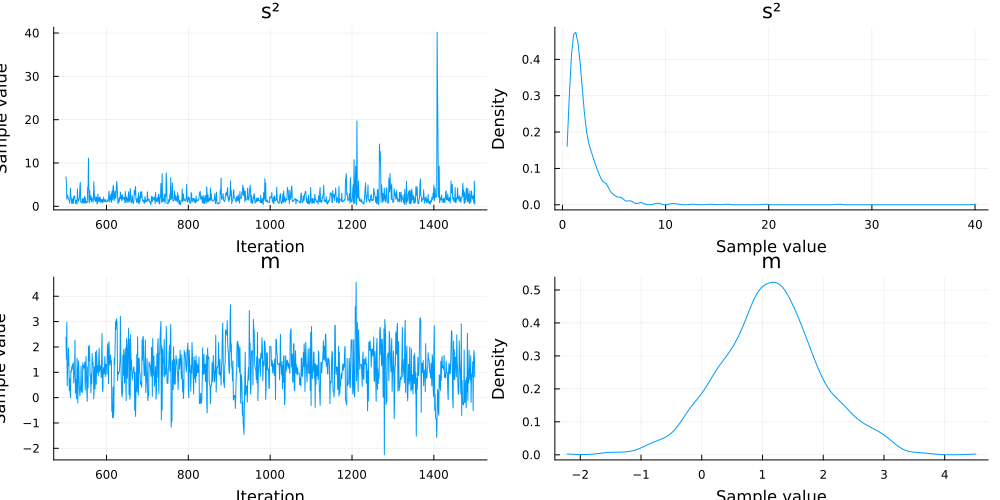

In [4]:
plot(chn)

In this case, because we use the [normal-inverse gamma distribution](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution) as a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior), we can compute its updated mean as follows:

In [5]:
s² = InverseGamma(2, 3)
m = Normal(0, 1)
data = [1.5, 2]
x_bar = mean(data)
N = length(data)

mean_exp = (m.σ * m.μ + N * x_bar) / (m.σ + N)

1.1666666666666667

We can also compute the updated variance

In [6]:
updated_alpha = shape(s²) + (N / 2)
updated_beta =
    scale(s²) +
    (1 / 2) * sum((data[n] - x_bar)^2 for n in 1:N) +
    (N * m.σ) / (N + m.σ) * ((x_bar)^2) / 2
variance_exp = updated_beta / (updated_alpha - 1)

2.0416666666666665

Finally, we can check if these expectations align with our HMC approximations from earlier. We can compute samples from a normal-inverse gamma following the equations given [here](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution#Generating_normal-inverse-gamma_random_variates).

In [7]:
function sample_posterior(alpha, beta, mean, lambda, iterations)
    samples = []
    for i in 1:iterations
        sample_variance = rand(InverseGamma(alpha, beta), 1)
        sample_x = rand(Normal(mean, sqrt(sample_variance[1]) / lambda), 1)
        samples = append!(samples, sample_x)
    end
    return samples
end

analytical_samples = sample_posterior(updated_alpha, updated_beta, mean_exp, 2, 1000);

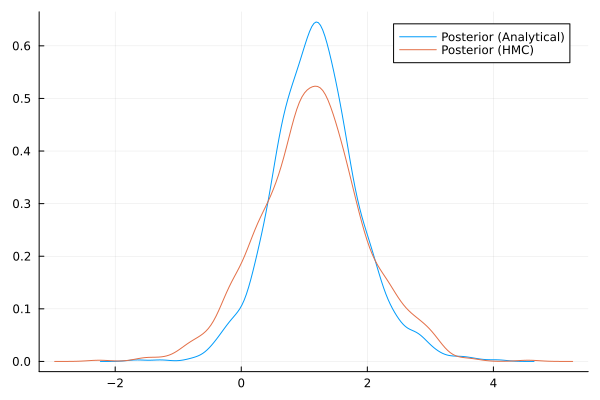

In [8]:
density(analytical_samples; label="Posterior (Analytical)")
density!(chn[:m]; label="Posterior (HMC)")

# References

- [ ] [Using Turing: Getting Started](https://turinglang.org/v0.29/docs/using-turing/get-started)